In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import  drive
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering


drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


Retrieve hero and player information:



In [2]:
heroes = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dota/hero_names2.csv") #underlord and arc warden appear in the hero name data but were not yet released, meaning they appear in 0 games
heroes

,name,hero_id,localized_name,role
0,npc_dota_hero_antimage,1,Anti-Mage,core
1,npc_dota_hero_axe,2,Axe,init
2,npc_dota_hero_bane,3,Bane,supp
3,npc_dota_hero_bloodseeker,4,Bloodseeker,core
4,npc_dota_hero_crystal_maiden,5,Crystal Maiden,supp
...,...,...,...,...
107,npc_dota_hero_terrorblade,109,Terrorblade,core
108,npc_dota_hero_phoenix,110,Phoenix,supp
109,npc_dota_hero_oracle,111,Oracle,supp
110,npc_dota_hero_winter_wyvern,112,Winter Wyvern,supp


In [3]:
players = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dota/players.csv")
players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,180,37,73,56,108,0,16,0,8840.0,5440.0,NaN,83.0,50.0,-957.0,NaN,NaN,212.0,3120.0,5145.0,1087.0,400.0,NaN,NaN,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,NaN,188.0,16.0,NaN,NaN,NaN,2.0,35.0,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,NaN,NaN,1650.0,3299.0,6676.0,4317.0,937.0,NaN,NaN,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,NaN,346.0,22.0,NaN,NaN,12.0,52.0,30.0,4.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,48,60,59,108,65,0,17,0,6692.0,8112.0,NaN,453.0,259.0,-1436.0,-1015.0,NaN,NaN,3142.0,2418.0,3697.0,400.0,NaN,NaN,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,NaN,643.0,17.0,5.0,NaN,7.0,8.0,28.0,NaN,1.0,18.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,NaN,NaN,938.0,4714.0,4104.0,10432.0,400.0,NaN,NaN,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,NaN,150.0,21.0,NaN,NaN,1.0,9.0,45.0,7.0,NaN,14.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,NaN,62.0,NaN,-1437.0,-1056.0,NaN,4194.0,3217.0,7467.0,9220.0,400.0,NaN,NaN,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,NaN,111.0,23.0,1.0,NaN,NaN,2.0,44.0,6.0,NaN,13.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,16,2,70,54.4912,22127,0,1227,249,41,0,50,141,168,23,0,21496.0,6025.0,596.0,1007.0,528.0,-4131.0,NaN,NaN,237.0,3860.0,9377.0,2940.0,400.0,NaN,NaN,4042.0,79.0,192.0,423.0,81.0,38.0,5.0,281.0,NaN,NaN,22.0,NaN,NaN,2.0,21.0,32.0,3.0,NaN,9.0,21.0,169.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,11,7,115,43.0999,12381,0,2269,135,63,166,30,36,139,23,0,16360.0,9653.0,1490.0,740.0,329.0,-2274.0,NaN,NaN,1587.0,4945.0,8292.0,4346.0,857.0,175.0,NaN,4412.0,NaN,89.0,625.0,75.0,NaN,4.0,162.0,2.0,224.0,21.0,NaN,NaN,NaN,9.0,42.0,7.0,NaN,13.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,11,2,92,18.1353,7050,872,87,79,48,152,108,102,117,18,0,8205.0,10012.0,NaN,600.0,303.0,-1287.0,NaN,NaN,NaN,386

Possible attributes for clustering:


In [4]:
players.columns

Index(['match_id', 'account_id', 'hero_id', 'player_slot', 'gold',
       'gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'stuns', 'hero_damage',
       'hero_healing', 'tower_damage', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'level', 'leaver_status', 'xp_hero', 'xp_creep',
       'xp_roshan', 'xp_other', 'gold_other', 'gold_death', 'gold_buyback',
       'gold_abandon', 'gold_sell', 'gold_destroying_structure',
       'gold_killing_heros', 'gold_killing_creeps', 'gold_killing_roshan',
       'gold_killing_couriers', 'unit_order_none',
       'unit_order_move_to_position', 'unit_order_move_to_target',
       'unit_order_attack_move', 'unit_order_attack_target',
       'unit_order_cast_position', 'unit_order_cast_target',
       'unit_order_cast_target_tree', 'unit_order_cast_no_target',
       'unit_order_cast_toggle', 'unit_order_hold_position',
       'unit_order_train_ability', 'unit_order_drop_item',


Attempt to cluster to find what attributes are relevant:

In [5]:
attributes = players[['hero_id', 'gold',
       'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'stuns', 'hero_damage',
       'hero_healing', 'tower_damage', 'level']] #possible relevant attributes

hero_dict = dict(zip(heroes['hero_id'],heroes['localized_name']))
hero_dict_rev = dict(zip(heroes['localized_name'], heroes['hero_id']))

hero_dict[0] = 'unknown'
attributes['name']  = attributes['hero_id'].apply(lambda x : hero_dict[x]) #ids to hero names
attributes = attributes.fillna(value=0)
attributes['stuns'].replace('None', 0, inplace=True) #making stuns numeric
attributes['stuns'] = pd.to_numeric(attributes['stuns'])
attributes['k/d'] = attributes.apply(lambda x : x['kills'] if x['deaths'] == 0 else (x['kills']/x['deaths']), axis = 1) #kill/death ratio to be used later, 0 deaths treated same as 1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
hero_means = attributes.groupby(['name']).mean() #getting the means for heroes
hero_means.drop('unknown',inplace=True)
hero_means.sort_values('hero_id')

,hero_id,gold,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level,k/d
name,,,,,,,,,,,,,,,
Anti-Mage,1.0,2392.246275,554.192742,580.392827,7.340996,5.449979,6.722222,10.741699,298.673585,4.774384,10162.878033,135.156769,3081.401767,20.574819,2.295656
Axe,2.0,1682.507933,400.109107,442.938274,8.525321,9.365138,10.498153,1.327755,136.269724,0.171975,11945.333188,14.217779,453.616605,18.033254,1.258256
Bane,3.0,1512.149628,295.293380,336.720329,4.766941,7.721112,11.811986,3.867607,32.764591,96.947184,7838.933803,167.141794,381.018801,15.563259,0.920094
Bloodseeker,4.0,1821.146143,447.641746,494.835927,9.657307,9.190122,9.746279,5.939445,165.670162,1.239450,13487.634641,740.771651,1449.624831,19.419824,1.457787
Crystal Maiden,5.0,1532.348713,314.668876,346.943411,4.483686,8.946215,14.027402,1.828830,48.836477,3.011080,8805.037726,142.610375,288.910018,15.789064,0.708599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Earth Spirit,107.0,1719.227564,332.400997,375.771011,5.356838,7.667023,15.289530,2.331553,52.301282,64.817438,10249.472222,731.684117,333.606125,16.221154,1.077073
Terrorblade,109.0,2469.381689,488.280464,493.556415,7.531915,7.255964,9.275306,7.647324,212.918117,0.052731,12729.525467,28.301741,3663.286267,18.959381,1.770451
Phoenix,110.0,2073.953120,364.729944,428.591945,6.465170,7.988775,15.667217,4.650050,80.664906,11.759792,13959.607131,1450.888082,457.317927,17.762298,1.208532


First attempt, cluster with k = 5 to try to identify positions 1-5:

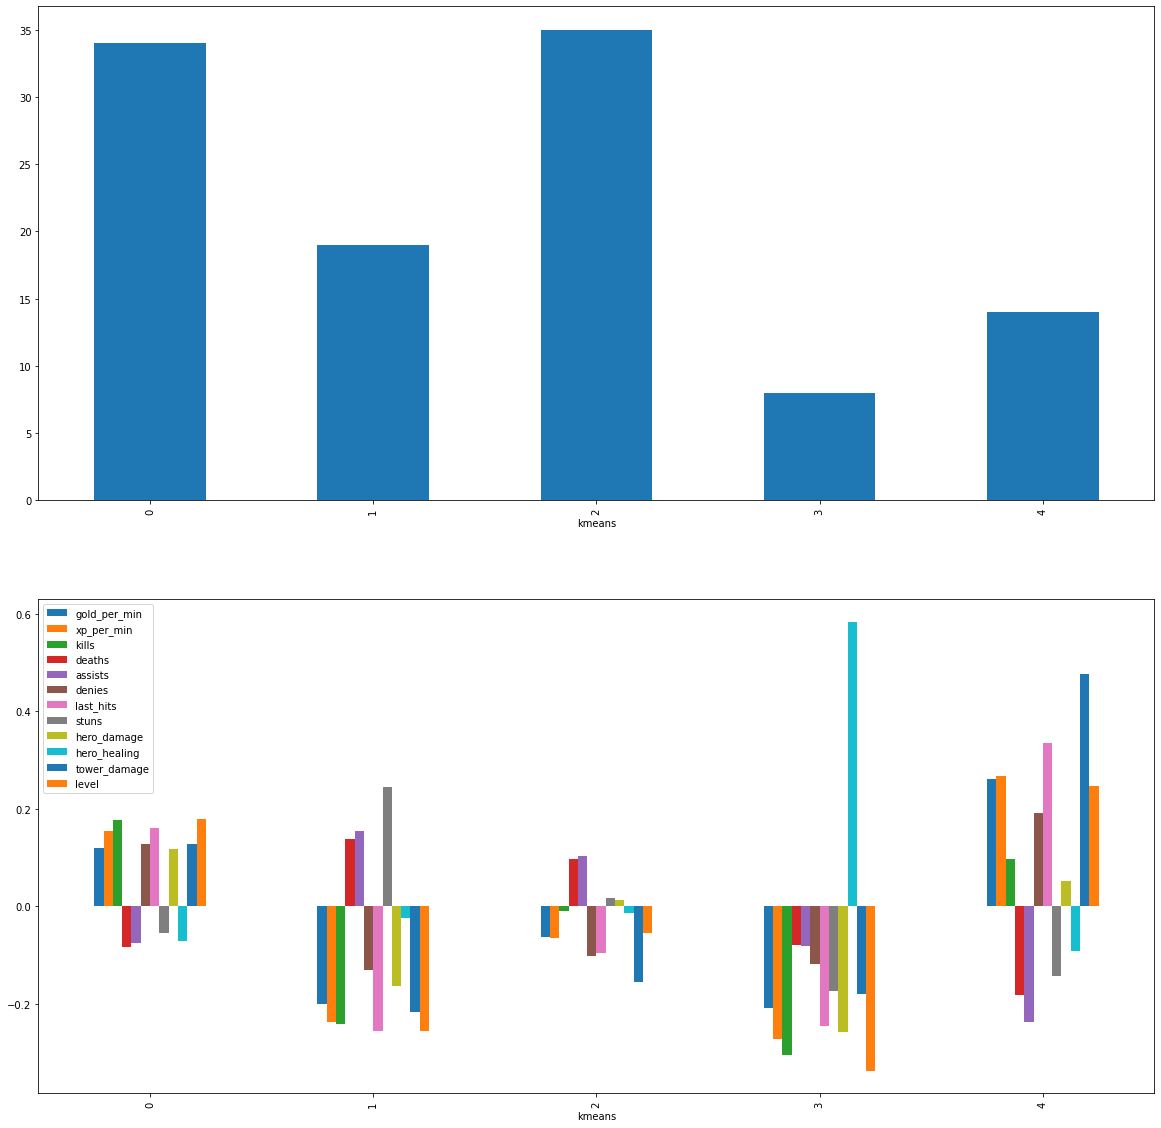

In [10]:


toCluster = hero_means[['gold_per_min', 'xp_per_min', 'kills', 'deaths','assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage', 'level']]

toClusterMean = toCluster.mean(axis=0) #normalization before
toClusterRange = toCluster.max(axis=0) - toCluster.min(axis=0)
toClusterNorm = (toCluster - toClusterMean) / toClusterRange
toCluster = toClusterNorm
k = 5
kmeans5 = KMeans(n_clusters=k,init = 'k-means++',random_state=1000).fit(toCluster)


toCluster['kmeans'] = kmeans5.labels_
k5attributes = toCluster.groupby(['kmeans']).mean()
k5attributes['count'] = toCluster.groupby(['kmeans'])['kills'].count()

# k5means = k5attributes.mean(axis=0) #normalization after
# k5range = k5attributes.max(axis=0) - k5attributes.min(axis=0)
# k5norm = (k5attributes - k5means) / k5range
# k5norm = k5norm 

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
k5attributes['count'].plot.bar(ax=ax1)
k5attributes.iloc[:,:-1].plot.bar(ax=ax2).legend() #change from k5attributes to k5norm for norm. after

In [11]:
toCluster['cluster'] = 'na'
toCluster.loc[(toCluster['kmeans']==0),'cluster'] = '2'
toCluster.loc[(toCluster['kmeans']==1),'cluster'] = '4'
toCluster.loc[(toCluster['kmeans']==2),'cluster'] = '3'
toCluster.loc[(toCluster['kmeans']==3),'cluster'] = '5'
toCluster.loc[(toCluster['kmeans']==4),'cluster'] = '1'


In [12]:
clusters_grouped_k5 = toCluster[['cluster','gold_per_min', 'xp_per_min', 'kills', 'deaths','assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage', 'level']].sort_values(['cluster'])
print(clusters_grouped_k5.to_string())

                    cluster  gold_per_min  xp_per_min     kills    deaths   assists    denies  last_hits     stuns  hero_damage  hero_healing  tower_damage     level
name                                                                                                                                                                 
Lycan                     1      0.151348    0.145748 -0.070588 -0.255833 -0.363203 -0.113797   0.224584 -0.185046    -0.117436     -0.021882      0.696082  0.103203
Clinkz                    1      0.139054    0.180954  0.310933 -0.144096 -0.392308  0.173749   0.075725 -0.205861     0.132460     -0.106612      0.565569  0.166772
Troll Warlord             1      0.143960    0.178053  0.055252 -0.027016 -0.223196  0.168116   0.207151 -0.121653     0.001866     -0.104225      0.412313  0.158214
Juggernaut                1      0.275062    0.294516  0.243473 -0.271885 -0.261940  0.319687   0.350280 -0.181158     0.112822     -0.102075      0.388813  0.269994
Temp

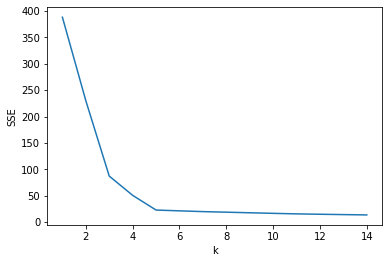

In [13]:
#Elbow Criterion
# data =  hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]
data = toClusterNorm
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

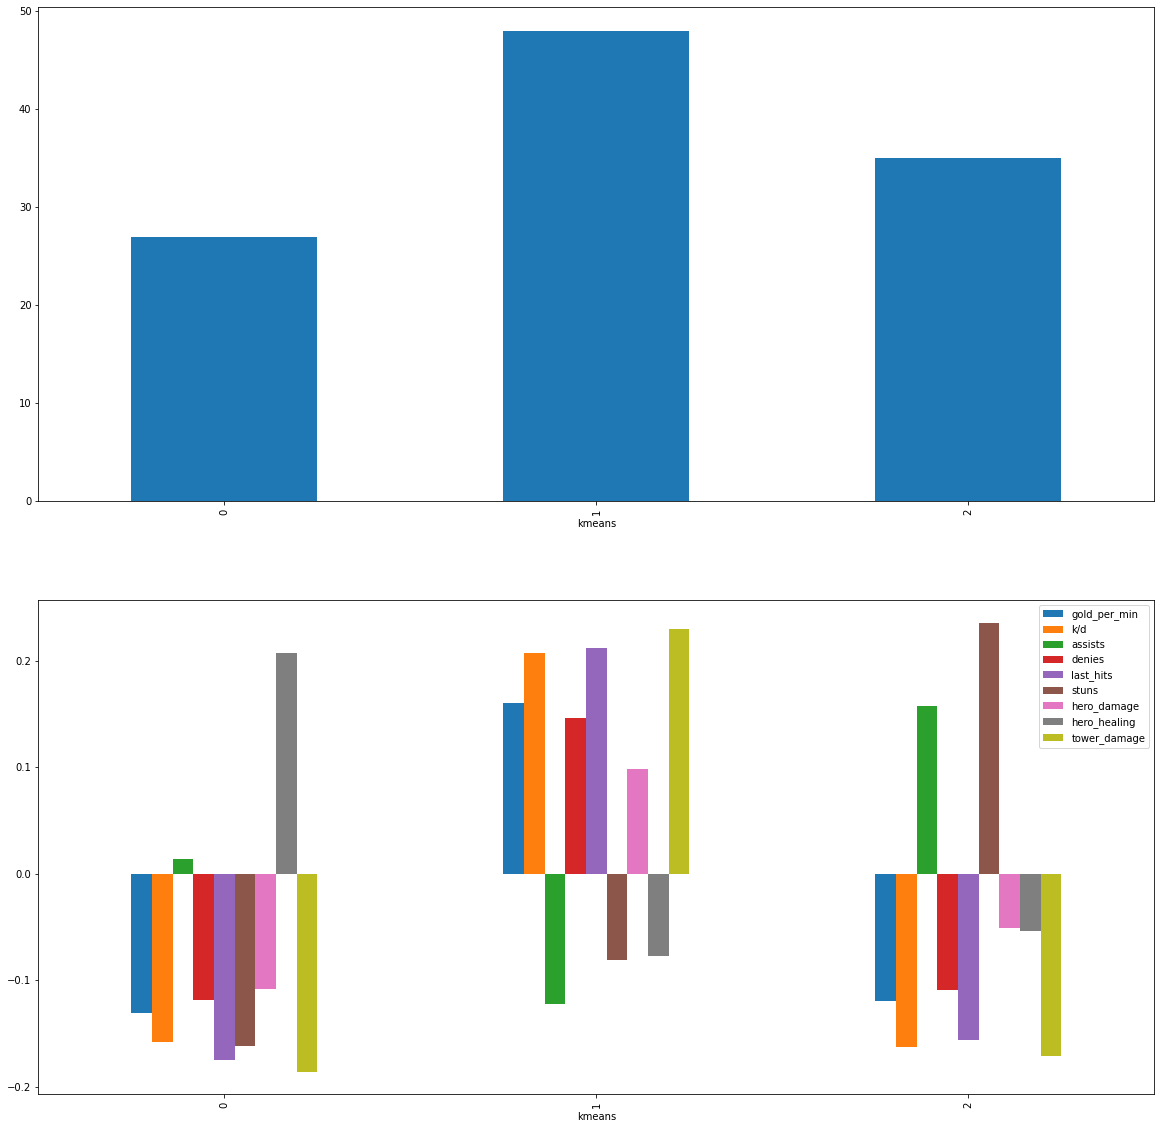

In [16]:

toCluster3 = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]

toClusterMean3 = toCluster3.mean(axis=0) #normalization before
toClusterRange3 = toCluster3.max(axis=0) - toCluster3.min(axis=0)
toClusterNorm3 = (toCluster3 - toClusterMean3) / toClusterRange3
toCluster3 = toClusterNorm3


k = 3
kmeans3 = KMeans(n_clusters=k,init = 'k-means++',random_state=1000).fit(toCluster3)
toCluster3['kmeans'] = kmeans3.labels_
k3attributes = toCluster3.groupby(['kmeans']).mean()
k3attributes['count'] = toCluster3.groupby(['kmeans'])['k/d'].count()

# k3means = k3attributes.mean(axis=0) #normalization after
# k3range = k3attributes.max(axis=0) - k3attributes.min(axis=0)
# k3norm = (k3attributes - k3means) / k3range
# k3norm = k3norm

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
k3attributes['count'].plot.bar(ax=ax1)
k3attributes.iloc[:,:-1].plot.bar(ax=ax2).legend()
# k3norm.iloc[:,:-1].plot.bar(ax=ax2).legend()

In [17]:
toCluster3['cluster'] = 'na'
toCluster3.loc[(toCluster3['kmeans']==0),'cluster'] = 'supp'
toCluster3.loc[(toCluster3['kmeans']==1),'cluster'] = 'core'
toCluster3.loc[(toCluster3['kmeans']==2),'cluster'] = 'init'

toCluster3['hero_id'] = toCluster3.apply(lambda x: hero_dict_rev[x.name], axis = 1)

In [18]:
clusters_grouped_k3 = toCluster3[['hero_id','cluster','gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']].sort_values(['cluster'])
clusters_grouped_k3.to_csv('/content/drive/MyDrive/heroCluster.csv',index=True)

print(clusters_grouped_k3.to_string())

                     hero_id cluster  gold_per_min       k/d   assists    denies  last_hits     stuns  hero_damage  hero_healing  tower_damage
name                                                                                                                                          
Morphling                 10    core      0.079088  0.332275 -0.152292  0.331466   0.142218  0.048626    -0.017295     -0.100870      0.163426
Ember Spirit             106    core      0.215497  0.413631  0.071520  0.126280   0.358990 -0.205760     0.265214     -0.106784      0.015428
Phantom Assassin          44    core      0.182373  0.270530 -0.129559  0.100487   0.232320 -0.136484     0.115238     -0.100863      0.084966
Faceless Void             41    core      0.136225  0.118306 -0.241250  0.176579   0.248378 -0.020208    -0.050421     -0.106377      0.070794
Gyrocopter                72    core      0.228064  0.287156  0.025099  0.444701   0.356482 -0.009638     0.268868     -0.105588      0.247761

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


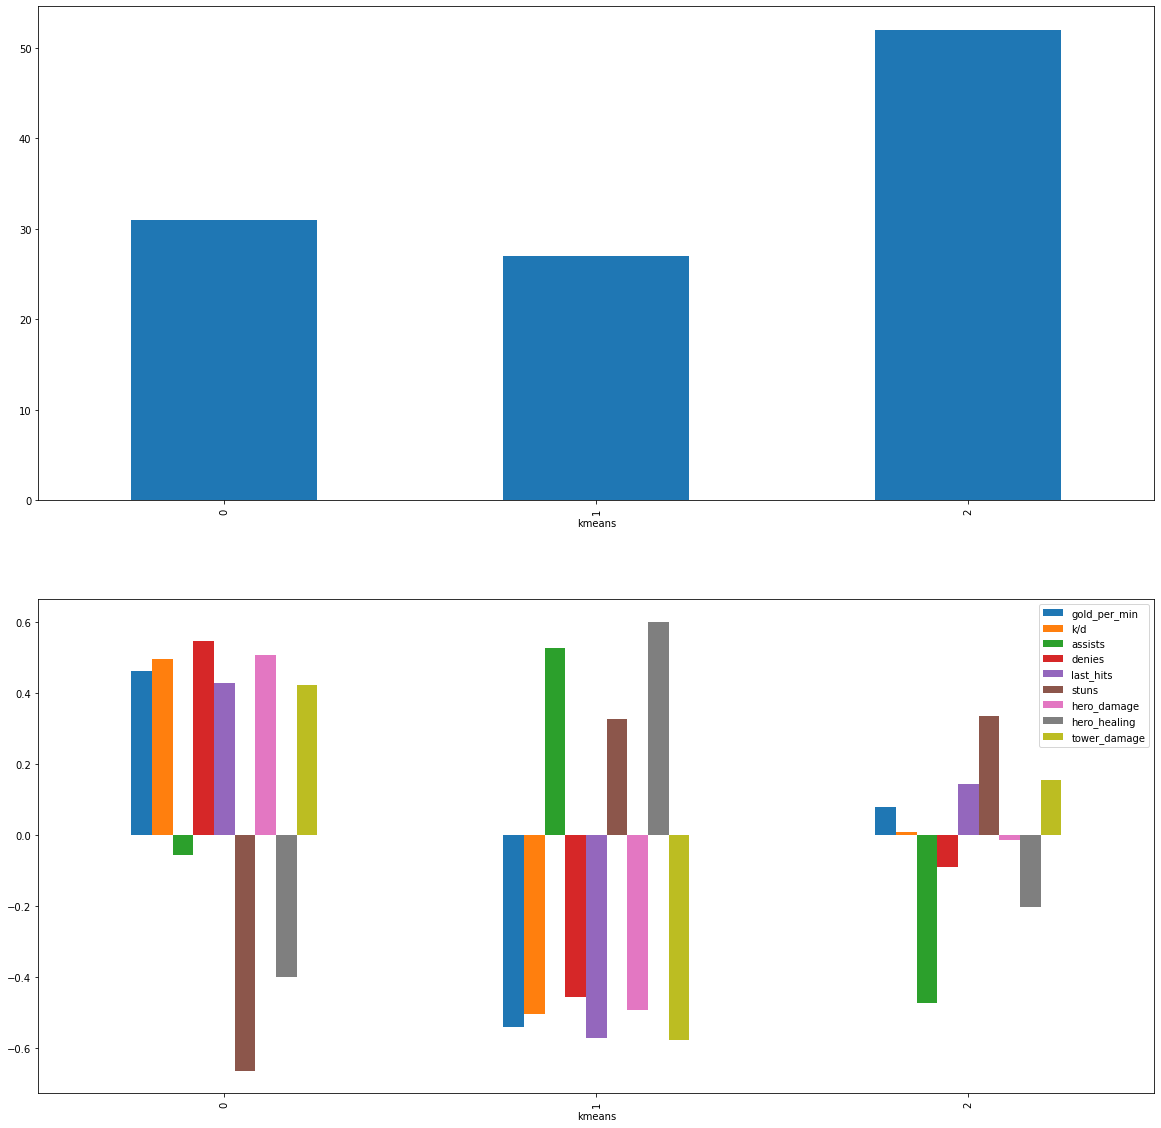

In [19]:

toCluster3_2 = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]
# toClusterMean3 = toCluster3.mean(axis=0)
# toClusterRange3 = toCluster3.max(axis=0) - toCluster3.min(axis=0)
# toClusterNorm3 = (toCluster3 - toClusterMean3) / toClusterRange3
# toCluster3 = toClusterNorm3


k = 3
kmeans3_2 = KMeans(n_clusters=k,init = 'k-means++',random_state=1000).fit(toCluster3_2)
toCluster3_2['kmeans'] = kmeans3_2.labels_
k3attributes_2 = toCluster3_2.groupby(['kmeans']).mean()
k3attributes_2['count'] = toCluster3_2.groupby(['kmeans'])['k/d'].count()
k3means_2 = k3attributes_2.mean(axis=0)
k3range_2 = k3attributes_2.max(axis=0) - k3attributes_2.min(axis=0)
k3norm_2 = (k3attributes_2 - k3means_2) / k3range_2
k3norm_2 = k3norm_2
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
k3attributes_2['count'].plot.bar(ax=ax1)
k3norm_2.iloc[:,:-1].plot.bar(ax=ax2).legend()

In [20]:
toCluster3_2['cluster'] = 'na'
toCluster3_2.loc[(toCluster3_2['kmeans']==0),'cluster'] = 'core'
toCluster3_2.loc[(toCluster3_2['kmeans']==1),'cluster'] = 'supp'
toCluster3_2.loc[(toCluster3_2['kmeans']==2),'cluster'] = 'init'

toCluster3_2['hero_id'] = toCluster3_2.apply(lambda x: hero_dict_rev[x.name], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [21]:
clusters_grouped_k3_2 = toCluster3_2[['hero_id','cluster','gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']].sort_values(['cluster'])
# clusters_grouped_k3_2.to_csv('/content/drive/MyDrive/heroCluster2.csv',index=True)

print(clusters_grouped_k3_2.to_string())

                     hero_id cluster  gold_per_min       k/d    assists     denies   last_hits       stuns   hero_damage  hero_healing  tower_damage
name                                                                                                                                                
Zeus                      22    core    406.194814  1.999709  18.238178   2.081717  109.482676    6.070095  23793.737198    130.565265    413.339943
Spectre                   67    core    495.294745  2.287298  16.876727   7.146396  214.003003    0.267740  18308.117117     47.866216   1647.875375
Sniper                    35    core    436.462589  1.685745  11.913888   8.857968  175.561565    0.330063  14849.123655      1.098976   1639.701759
Ember Spirit             106    core    494.988318  2.403940  12.543874   6.374618  222.950617    0.134780  17031.444577      0.787070   1348.611974
Shadow Fiend              11    core    551.266302  2.300273   9.994120  14.526842  246.708943    1.407011

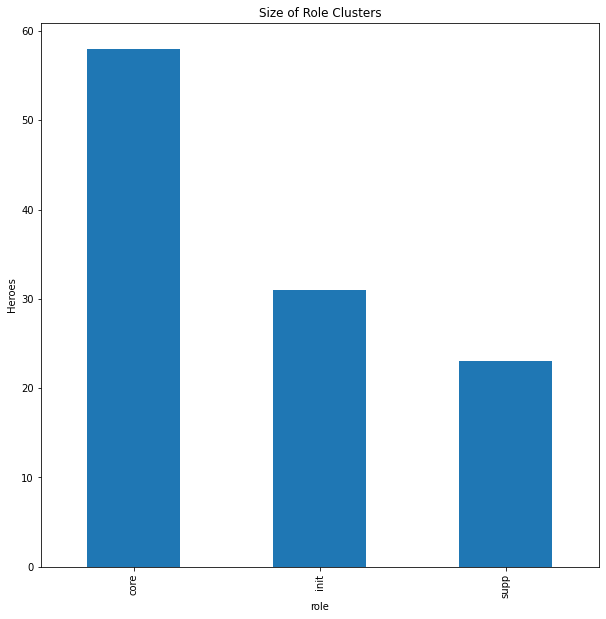

In [22]:

dfg2 = heroes.groupby(['role'])['hero_id'].count()
dfg2.plot(kind='bar', title='Size of Role Clusters', ylabel='Heroes',
         xlabel='role', figsize=(10, 10))

In [23]:
def clusterCM(r, df, cm):
  gtrole = df[df['localized_name']==r.name]['role'].iloc[0]
  if r['cluster'] == 'core':
    if gtrole == 'core':
      cm[0][0] += 1
    elif gtrole == 'supp':
      cm[1][0] += 1
    elif gtrole == 'init':
      cm[2][0] += 1
  elif r['cluster'] == 'init':
    if gtrole == 'core':
      cm[0][1] += 1
    elif gtrole == 'init':
      cm[1][1] += 1
    elif gtrole == 'supp':
      cm[2][1] += 1
  elif r['cluster'] == 'supp':
    if gtrole == 'core':
      cm[0][2] += 1
    elif gtrole == 'init':
      cm[1][2] += 1
    elif gtrole == 'supp':
      cm[2][2] += 1


cm = np.zeros((3,3))
toCluster3.apply(lambda x: clusterCM(x, heroes, cm), axis = 1)
cmdf = pd.DataFrame(cm, columns=['core','init', 'supp',], index = ['core','init', 'supp'])
print("K = 3, Normalizing Before")
print("Actual (index) vs Predicted (columns)")

print(cmdf)


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
print("FP: " + str(FP) + ", total: " + str(np.sum(FP)))
print("FN: " + str(FN) + ", total: " + str(np.sum(FN)))
print("TP: " + str(TP) + ", total: " + str(np.sum(TP)))
pre = TP/(TP+FP)
ovrpre = np.sum(TP)/(np.sum(TP)+np.sum(FP))
rec = TP/(TP+FN)
ovrrec = np.sum(TP)/(np.sum(TP)+np.sum(FN))
f1 = (2*pre*rec)/(pre+rec)
ovrf1 = (2*ovrpre*ovrrec)/(ovrpre+ovrrec)
ovracc =  np.sum(TP) / (np.sum(cm))
print("pre: " + str(pre) + ", overall: " + str(ovrpre))
print("rec: " + str(rec) + ", overall: " + str(ovrrec))
print("f1: " + str(f1) + ", overall: " + str(ovrf1))

print("overall accuracy : " + str(ovracc))

print("\n")



cm = np.zeros((3,3))
toCluster3_2.apply(lambda x: clusterCM(x, heroes, cm), axis = 1)
cmdf = pd.DataFrame(cm, columns=['core','init', 'supp',], index = ['core','init', 'supp'])
print("K = 3, Normalizing After")
print("Actual (index) vs Predicted (columns)")
print(cmdf)


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
print("FP: " + str(FP) + ", total: " + str(np.sum(FP)))
print("FN: " + str(FN) + ", total: " + str(np.sum(FN)))
print("TP: " + str(TP) + ", total: " + str(np.sum(TP)))
pre = TP/(TP+FP)
ovrpre = np.sum(TP)/(np.sum(TP)+np.sum(FP))
rec = TP/(TP+FN)
ovrrec = np.sum(TP)/(np.sum(TP)+np.sum(FN))
f1 = (2*pre*rec)/(pre+rec)
ovrf1 = (2*ovrpre*ovrrec)/(ovrpre+ovrrec)
ovracc =  np.sum(TP) / (np.sum(cm))
print("pre: " + str(pre) + ", overall: " + str(ovrpre))
print("rec: " + str(rec) + ", overall: " + str(ovrrec))
print("f1: " + str(f1) + ", overall: " + str(ovrf1))

print("overall accuracy : " + str(ovracc))

K = 3, Normalizing Before
Actual (index) vs Predicted (columns)
      core  init  supp
core  48.0   5.0   4.0
init   0.0  24.0   6.0
supp   0.0   6.0  17.0
FP: [ 0. 11. 10.], total: 21.0
FN: [9. 6. 6.], total: 21.0
TP: [48. 24. 17.], total: 89.0
pre: [1.         0.68571429 0.62962963], overall: 0.8090909090909091
rec: [0.84210526 0.8        0.73913043], overall: 0.8090909090909091
f1: [0.91428571 0.73846154 0.68      ], overall: 0.8090909090909091
overall accuracy : 0.8090909090909091


K = 3, Normalizing After
Actual (index) vs Predicted (columns)
      core  init  supp
core  28.0  28.0   1.0
init   1.0  18.0  10.0
supp   2.0   6.0  16.0
FP: [ 3. 34. 11.], total: 48.0
FN: [29. 11.  8.], total: 48.0
TP: [28. 18. 16.], total: 62.0
pre: [0.90322581 0.34615385 0.59259259], overall: 0.5636363636363636
rec: [0.49122807 0.62068966 0.66666667], overall: 0.5636363636363636
f1: [0.63636364 0.44444444 0.62745098], overall: 0.5636363636363636
overall accuracy : 0.5636363636363636


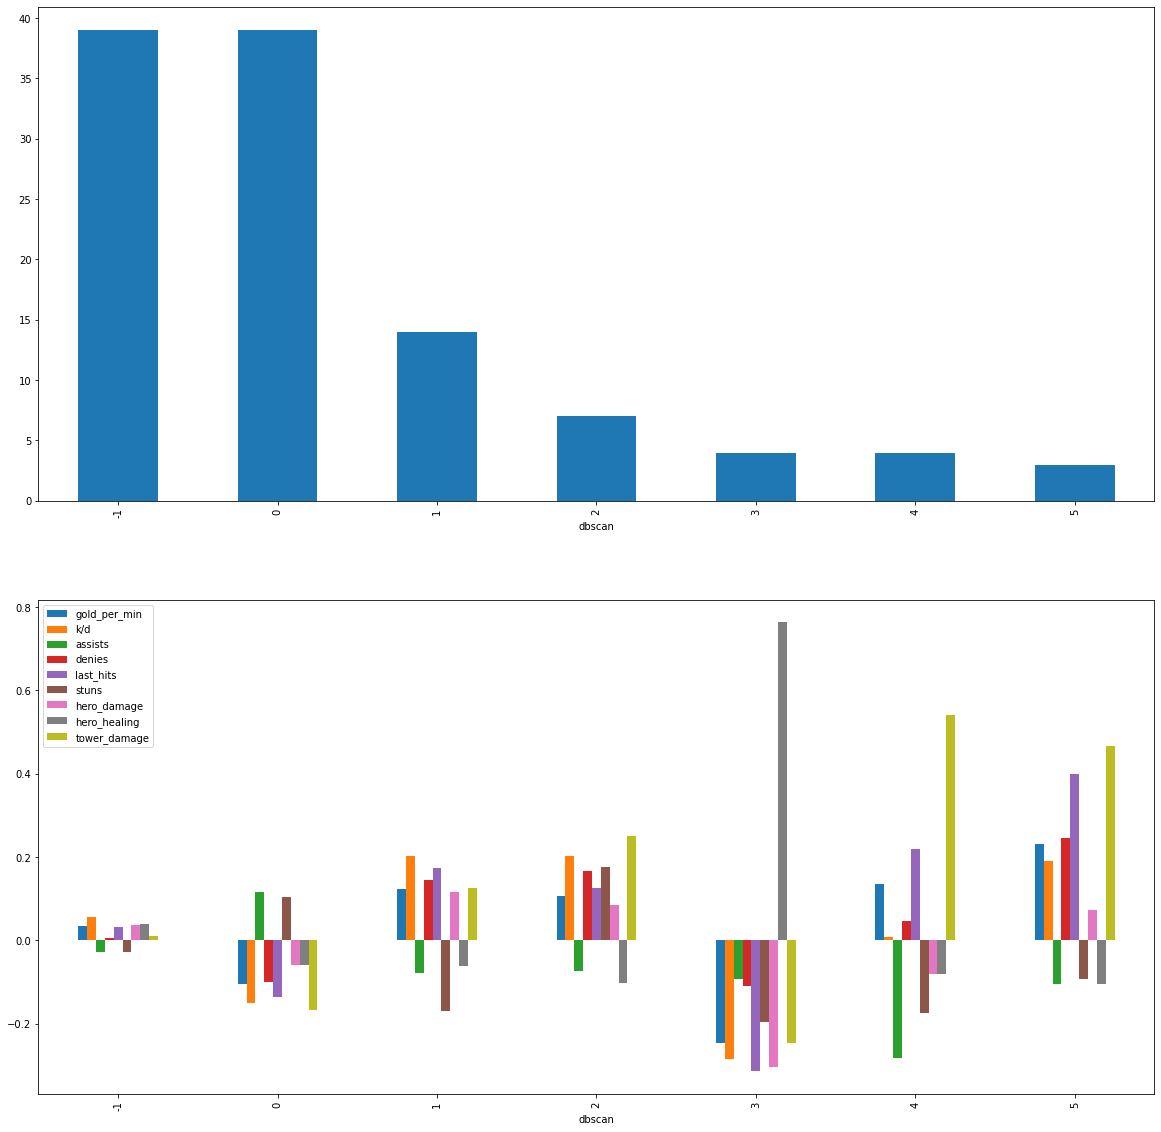

In [24]:
toClusterDB = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]
eps = 0.305
ms = 3
toClusterMeanDB = toClusterDB.mean(axis=0)
toClusterRangeDB = toClusterDB.max(axis=0) - toClusterDB.min(axis=0)
toClusterNormDB = (toClusterDB - toClusterMeanDB) / toClusterRangeDB
toClusterDB = toClusterNormDB


dbcluster = DBSCAN(eps=eps, min_samples = ms).fit(toClusterDB)

toClusterDB['dbscan'] = dbcluster.labels_
DBattributes = toClusterDB.groupby(['dbscan']).mean()
DBattributes['count'] = toClusterDB.groupby(['dbscan'])['gold_per_min'].count()
# DBmeans = DBattributes.mean(axis=0)
# DBrange = DBattributes.max(axis=0) - DBattributes.min(axis=0)
# DBnorm = (DBattributes - DBmeans) / DBrange
# DBnorm = DBnorm
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
DBattributes['count'].plot.bar(ax=ax1)
DBattributes.iloc[:,:-1].plot.bar(ax=ax2).legend()

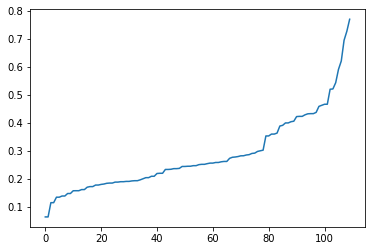

In [25]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(toClusterDB)
distances, indices = nbrs.kneighbors(toClusterDB)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [26]:
toClusterDB['cluster'] = 'na'
toClusterDB.loc[(toClusterDB['dbscan']==0),'cluster'] = '1'
toClusterDB.loc[(toClusterDB['dbscan']==1),'cluster'] = '2'
toClusterDB.loc[(toClusterDB['dbscan']==2),'cluster'] = '3'
toClusterDB.loc[(toClusterDB['dbscan']==3),'cluster'] = '4'
toClusterDB.loc[(toClusterDB['dbscan']==4),'cluster'] = '5'
toClusterDB.loc[(toClusterDB['dbscan']==5),'cluster'] = '6'
toClusterDB.loc[(toClusterDB['dbscan']==6),'cluster'] = '7'

toClusterDB.loc[(toClusterDB['dbscan']==-1),'cluster'] = '-1'


toClusterDB['hero_id'] = toClusterDB.apply(lambda x: hero_dict_rev[x.name], axis = 1)

In [ ]:
clusters_grouped_DB = toClusterDB[['hero_id','cluster','gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']].sort_values(['cluster'])

# clusters_grouped_k3.to_csv('/content/drive/MyDrive/heroCluster2.csv',index=True)
print(clusters_grouped_DB.to_string())

                     hero_id cluster  gold_per_min       k/d   assists    denies  last_hits     stuns  hero_damage  hero_healing  tower_damage
name                                                                                                                                          
Abaddon                  102      -1     -0.097120 -0.111637  0.079843 -0.101865  -0.156616 -0.195563    -0.112320      0.338016     -0.078386
Riki                      32      -1      0.069623  0.617717 -0.173027  0.012535  -0.111073 -0.167604     0.166227     -0.102133     -0.031410
Pugna                     45      -1     -0.125214 -0.217362  0.083096 -0.104054  -0.139019 -0.201193     0.054012      0.059488      0.128487
Phoenix                  110      -1     -0.093152 -0.088420  0.322550  0.000488  -0.169710 -0.104309     0.107872      0.180966     -0.231222
Outworld Devourer         76      -1      0.064242  0.226116 -0.255963  0.510251   0.084948  0.685884     0.033162     -0.085335     -0.039662

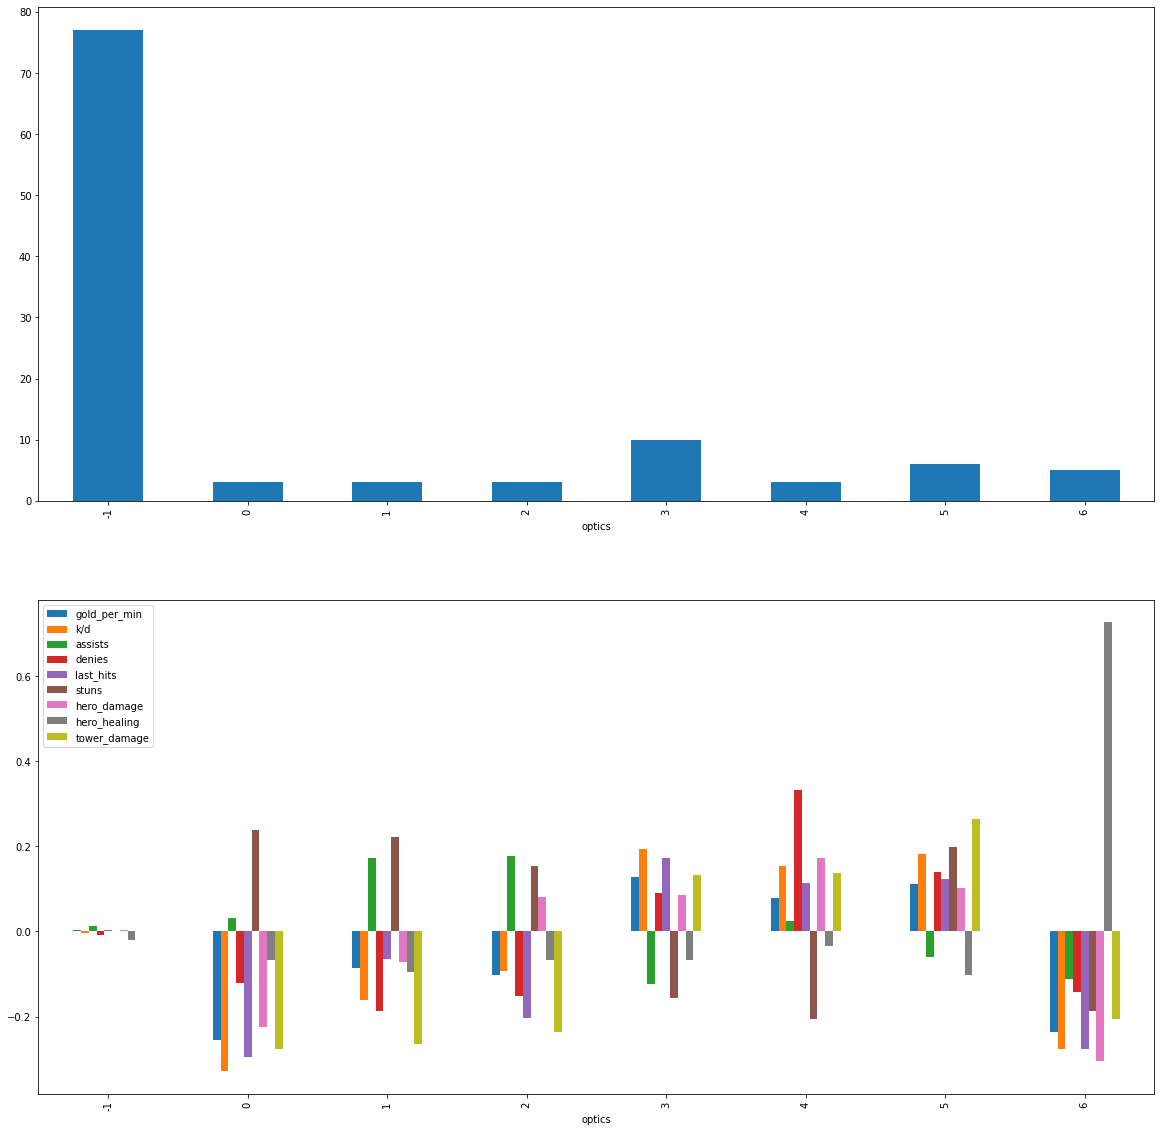

In [27]:
# toClusterOP = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]
toClusterOP = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]

toClusterMeanOP = toClusterOP.mean(axis=0)
toClusterRangeOP = toClusterOP.max(axis=0) - toClusterOP.min(axis=0)
toClusterNormOP = (toClusterOP - toClusterMeanOP) / toClusterRangeOP
toClusterOP = toClusterNormOP


eps = .5
ms = 3

OPcluster = OPTICS(max_eps=eps, min_samples = ms).fit(toClusterOP)

toClusterOP['optics'] = OPcluster.labels_
OPattributes = toClusterOP.groupby(['optics']).mean()
OPattributes['count'] = toClusterOP.groupby(['optics'])['gold_per_min'].count()
# OPmeans = OPattributes.mean(axis=0)
# OPrange = OPattributes.max(axis=0) - OPattributes.min(axis=0)
# OPnorm = (OPattributes - OPmeans) / OPrange
# OPnorm = OPnorm
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
OPattributes['count'].plot.bar(ax=ax1)
OPattributes.iloc[:,:-1].plot.bar(ax=ax2).legend()

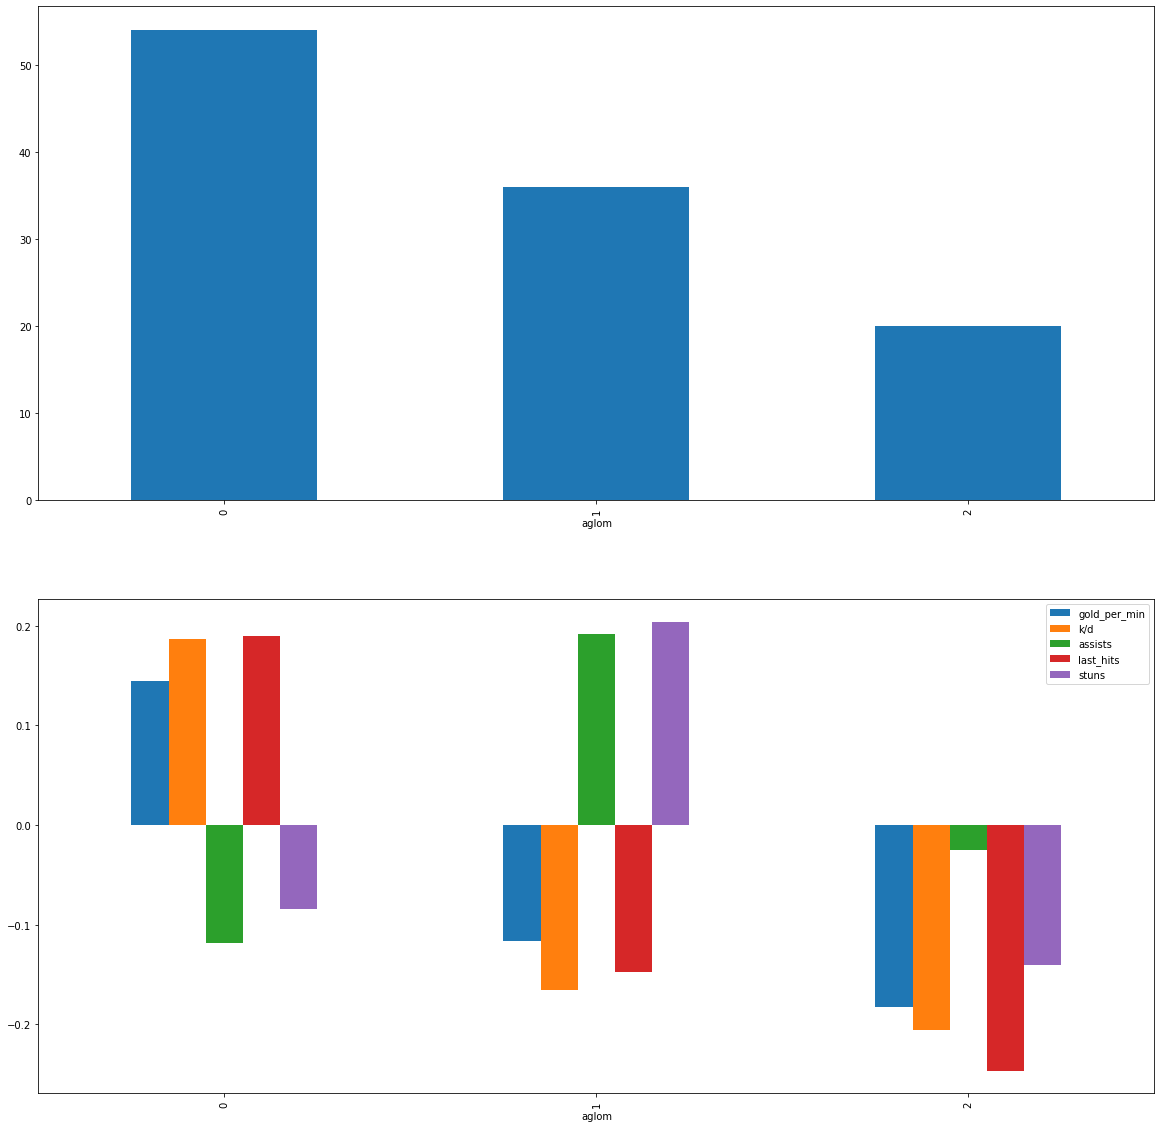

In [28]:


# toClusterAG = hero_means[['gold_per_min', 'k/d', 'assists', 'denies', 'last_hits', 'stuns', 'hero_damage','hero_healing', 'tower_damage']]
toClusterAG = hero_means[['gold_per_min', 'k/d', 'assists', 'last_hits', 'stuns']]


toClusterMeanAG = toClusterAG.mean(axis=0)
toClusterRangeAG = toClusterAG.max(axis=0) - toClusterAG.min(axis=0)
toClusterNormAG = (toClusterAG - toClusterMeanAG) / toClusterRangeAG
toClusterAG = toClusterNormAG



AGcluster = AgglomerativeClustering(n_clusters= 3, linkage='ward').fit(toClusterAG)

toClusterAG['aglom'] = AGcluster.labels_
AGattributes = toClusterAG.groupby(['aglom']).mean()
AGattributes['count'] = toClusterAG.groupby(['aglom'])['gold_per_min'].count()

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
AGattributes['count'].plot.bar(ax=ax1)
AGattributes.iloc[:,:-1].plot.bar(ax=ax2).legend()

In [29]:
toClusterAG['cluster'] = 'na'
toClusterAG.loc[(toClusterAG['aglom']==0),'cluster'] = 'core'
toClusterAG.loc[(toClusterAG['aglom']==1),'cluster'] = 'init'
toClusterAG.loc[(toClusterAG['aglom']==2),'cluster'] = 'supp'


toClusterAG['hero_id'] = toClusterAG.apply(lambda x: hero_dict_rev[x.name], axis = 1)

In [30]:
clusters_grouped_AG = toClusterAG[['hero_id','cluster','gold_per_min', 'k/d', 'assists', 'last_hits', 'stuns']].sort_values(['cluster'])

# clusters_grouped_k3.to_csv('/content/drive/MyDrive/heroCluster2.csv',index=True)
print(clusters_grouped_AG.to_string())

                     hero_id cluster  gold_per_min       k/d   assists  last_hits     stuns
name                                                                                       
Morphling                 10    core      0.079088  0.332275 -0.152292   0.142218  0.048626
Faceless Void             41    core      0.136225  0.118306 -0.241250   0.248378 -0.020208
Phantom Lancer            12    core      0.133238  0.170130 -0.171803   0.288086 -0.204251
Huskar                    59    core      0.083563  0.055487 -0.246526  -0.022226 -0.205971
Invoker                   74    core      0.108250  0.299530  0.030278   0.064567  0.220714
Sven                      18    core      0.156407  0.060053 -0.090189   0.265543  0.173237
Storm Spirit              17    core      0.074074  0.105598 -0.009891   0.110321  0.013192
Juggernaut                 8    core      0.275062  0.421150 -0.261940   0.350280 -0.181158
Spectre                   67    core      0.216223  0.364643  0.419761   0.32574

In [31]:
cm = np.zeros((3,3))
toClusterAG.apply(lambda x: clusterCM(x, heroes, cm), axis = 1)
cmdf = pd.DataFrame(cm, columns=['core','init', 'supp',], index = ['core','init', 'supp'])
print("AGLOM, Normalizing After")
print("Actual (index) vs Predicted (columns)")
print(cmdf)


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
print("FP: " + str(FP) + ", total: " + str(np.sum(FP)))
print("FN: " + str(FN) + ", total: " + str(np.sum(FN)))
print("TP: " + str(TP) + ", total: " + str(np.sum(TP)))
pre = TP/(TP+FP)
ovrpre = np.sum(TP)/(np.sum(TP)+np.sum(FP))
rec = TP/(TP+FN)
ovrrec = np.sum(TP)/(np.sum(TP)+np.sum(FN))
f1 = (2*pre*rec)/(pre+rec)
ovrf1 = (2*ovrpre*ovrrec)/(ovrpre+ovrrec)
ovracc =  np.sum(TP) / (np.sum(cm))
print("pre: " + str(pre) + ", overall: " + str(ovrpre))
print("rec: " + str(rec) + ", overall: " + str(ovrrec))
print("f1: " + str(f1) + ", overall: " + str(ovrf1))

print("overall accuracy : " + str(ovracc))

AGLOM, Normalizing After
Actual (index) vs Predicted (columns)
      core  init  supp
core  50.0   5.0   2.0
init   1.0  23.0   4.0
supp   3.0   8.0  14.0
FP: [ 4. 13.  6.], total: 23.0
FN: [ 7.  5. 11.], total: 23.0
TP: [50. 23. 14.], total: 87.0
pre: [0.92592593 0.63888889 0.7       ], overall: 0.7909090909090909
rec: [0.87719298 0.82142857 0.56      ], overall: 0.7909090909090909
f1: [0.9009009  0.71875    0.62222222], overall: 0.7909090909090909
overall accuracy : 0.7909090909090909
